In [67]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split


In [36]:
meta_data = pd.read_excel("D:\新传数据挖掘比赛\Code\Contest\data_minig_contest_new_media\data\combine_data_v2.xlsx")
y_m_data = pd.read_excel("D:\新传数据挖掘比赛\Code\Contest\data_minig_contest_new_media\data\heat_events.xlsx")
y_data = y_m_data["热度"]

In [23]:
print(meta_data.shape)
print(y_data.shape)
assert y_data.shape[0]==meta_data.shape[0]

(3920, 55)
(3920,)


In [30]:
meta_data[meta_data.index==0]

,序号,时间衰减系数,点赞-mean,点赞-max,点赞-var,点赞-sum,转发-mean,转发-max,转发-var,转发-sum,...,标题/微博内容-情感极性值-sum,一次转发,二次转发,三次转发,四次转发,大于四次转发,总转发次数,大于等于四次转发,得分,归1化
0,1,1.410959,0.0,0.0,0.0,0.0,0.057,51.0,2.608359,57.0,...,3677.3,799,50,19,8,18,894,26,0.000104,0.000228


In [60]:

def remove_invalid_rows(x_data):
    # 复制输入数据以保留原始数据不变
    x_data_process = x_data.copy()
    
    # 找到连续为空值或NAN的行
    is_invalid_row = x_data_process.isnull().any(axis=1)
    is_invalid_row |= x_data_process.isna().any(axis=1)
    # print("空无效值值列：",np.where(is_invalid_row[0]))
    # 找到连续13列值为0的行   注意：存在转发点赞评论为零的经过实验发现是12列最多，最后得到结果与人眼观测结果一致，得到所有去除后的数据  
    is_invalid_row |= (x_data_process == 0).astype(int).rolling(13, axis=1).sum().eq(13).any(axis=1)
    # 获取需要删除的行的索引
    invalid_row_indices = np.where(is_invalid_row)[0]
    
    # 删除无效行
    x_data_process.drop(x_data_process.index[invalid_row_indices], inplace=True)
    
    # 返回处理后的数据和删除的行索引
    return x_data_process, invalid_row_indices

# 使用示例
x_data_process, removed_indices = remove_invalid_rows(meta_data)

print("删除的行索引：", removed_indices)
print("处理后的数据：")
print(x_data_process)
print("removed_indices:",removed_indices)

删除的行索引： [  21   30   58   75   94   96   98  101  103  113  122  126  133  153
  157  164  167  180  181  194  195  208  211  216  236  250  298  341
  348  358  400  404  430  484  487  628  644  675  726  771  792  823
  840  895  922  974  979 1014 1097 1116 1286 1292 1471 1539 1547 1572
 1573 1626 1628 1697 1721 1880 2005 2073 2101 2423 2733 2841 2974 3378
 3582]
处理后的数据：
        序号    时间衰减系数   点赞-mean  点赞-max    点赞-var  点赞-sum   转发-mean  转发-max  \
0        1  1.410959  0.000000     0.0  0.000000     0.0  0.057000    51.0   
1        2  1.115068  0.000000     0.0  0.000000     0.0  0.021000    10.0   
2        3  1.479452  0.000000     0.0  0.000000     0.0  0.104000    48.0   
3        4  1.479452  0.000000     0.0  0.000000     0.0  0.057000    19.0   
4        5  1.479452  0.000000     0.0  0.000000     0.0  0.008000     2.0   
...    ...       ...       ...     ...       ...     ...       ...     ...   
3915  3996  0.778082  0.000000     0.0  0.000000     0.0  0.026316     3.0  

In [63]:
# 注意此处行号与excel中显示的行号数字减2
y_data_clean = y_data.drop(y_data.index[removed_indices]) 

In [66]:
# check data shape
assert y_data_clean.shape[0]==x_data_process.shape[0]
assert y_data.shape[0]==meta_data.shape[0]

### GDBT Implement

In [88]:
X_train, X_test, y_train, y_test = train_test_split(x_data_process, y_data_clean, test_size=0.2, random_state=1)

In [69]:
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 创建GradientBoostingRegressor模型
model = GradientBoostingRegressor()

# 定义参数搜索空间
# Best parameters {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5]
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# 拟合训练数据
grid_search.fit(X_train, y_train)

# 输出最佳参数组合
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# 保存最佳模型
joblib.dump(grid_search.best_estimator_, 'best_model.pkl')

# 加载最佳模型
loaded_model = joblib.load('best_model.pkl')

# 使用加载的模型进行预测
y_pred = loaded_model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean squared error: 0.3177854920633244


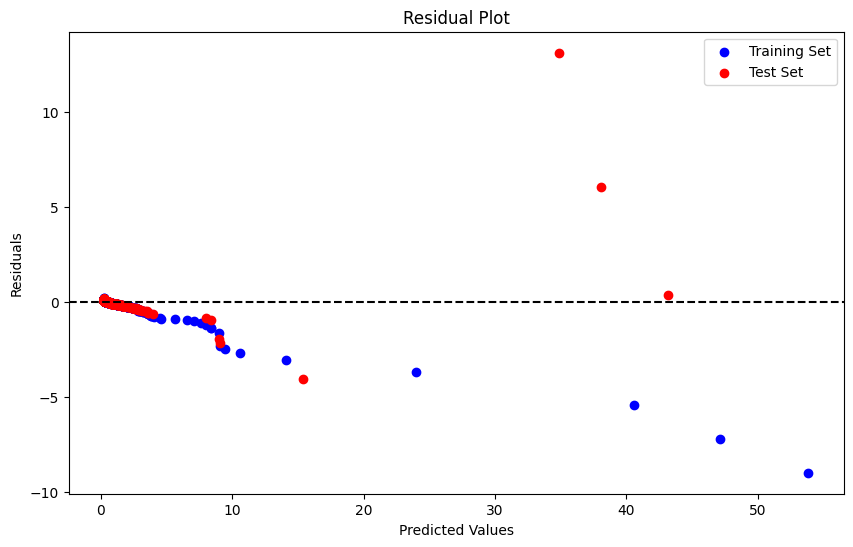

In [71]:
import matplotlib.pyplot as plt
# 在训练集和测试集上进行预测
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)

# 计算预测与真实值之间的残差
train_residuals = y_train_pred - y_train
test_residuals = y_test_pred - y_test

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, train_residuals, c='blue', label='Training Set')
plt.scatter(y_test_pred, test_residuals, c='red', label='Test Set')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()